In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os
import sys
sys.path.append(os.path.join(os.path.dirname('__file__'), '../'))

import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import random
from jax_cltv.datasets.dummy import DummySubscriptions
from jax_cltv.models.mle import MLE
from jax_cltv.dists.normal import rv_samples as normal_rv_samples
from jax_cltv.dists.geom import Geometric, neg_loglikelihood, survival_functions
from jax_cltv.plots.plot_data import plot_churns, plot_survives
from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

/Users/yukoga/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
def init_variables(to_delete: list) -> None:
    for v in to_delete:
        try: 
            del v
        except:
            pass

In [3]:
theta_true_1 = 0.7
theta_true_2 = 0.1

# ds1, data1 = DummySubscriptions(p=theta_true_1, size=800)()
# ds2, data2 = DummySubscriptions(p=theta_true_2, size=200)()
df1 = DummySubscriptions(p=theta_true_1, size=800).to_pandas()
df2 = DummySubscriptions(p=theta_true_2, size=200).to_pandas()

In [4]:
df1['segment'] = 'A'
df2['segment'] = 'B'

df = pd.concat([df2, df1], ignore_index=True)
df = df.fillna(0)

In [ ]:
df

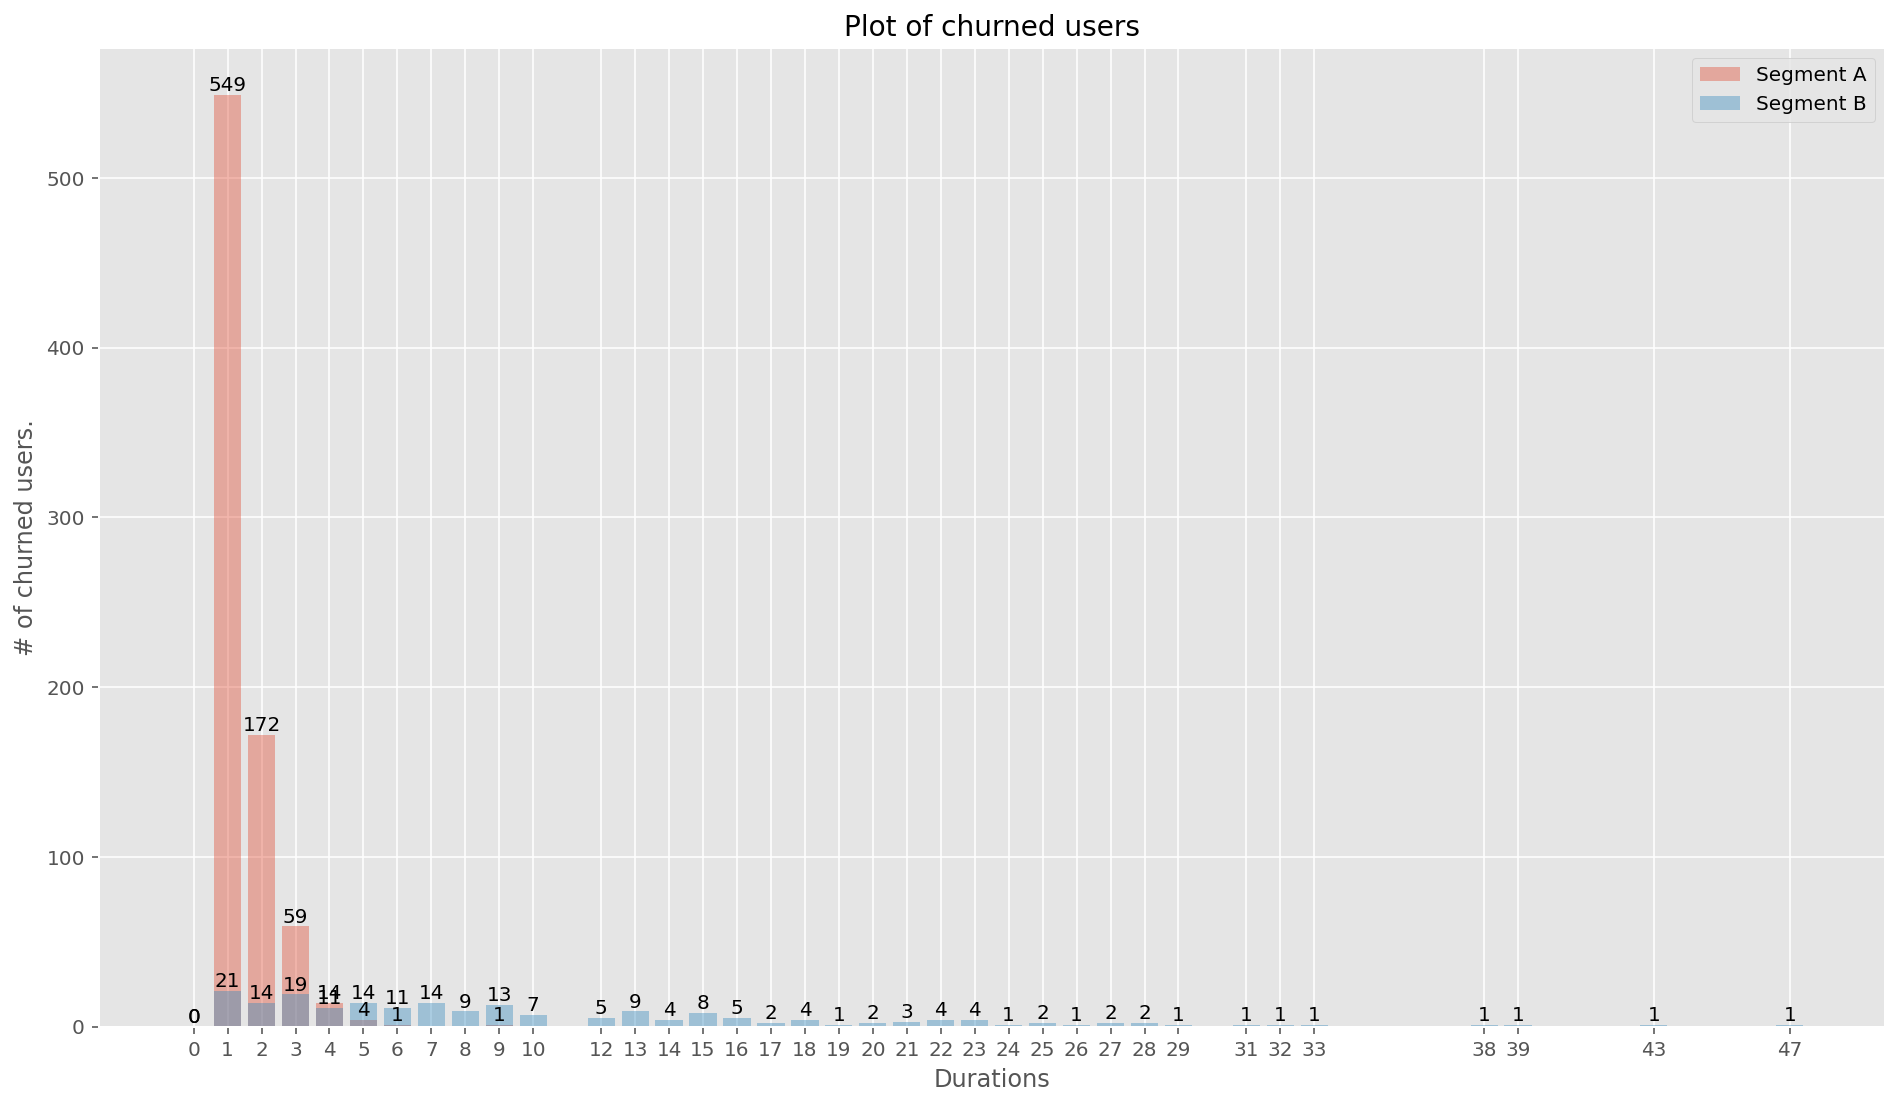

In [5]:
ax = plot_churns(df[df['segment']=='A'], label='Segment A', yscale='linear', density=False)  #, bar_label=None, theta=0.7)
ax = plot_churns(df[df['segment']=='B'], label='Segment B', yscale='linear', density=False, ax=ax)  #, bar_label=None, theta=0.1)
plt.show()

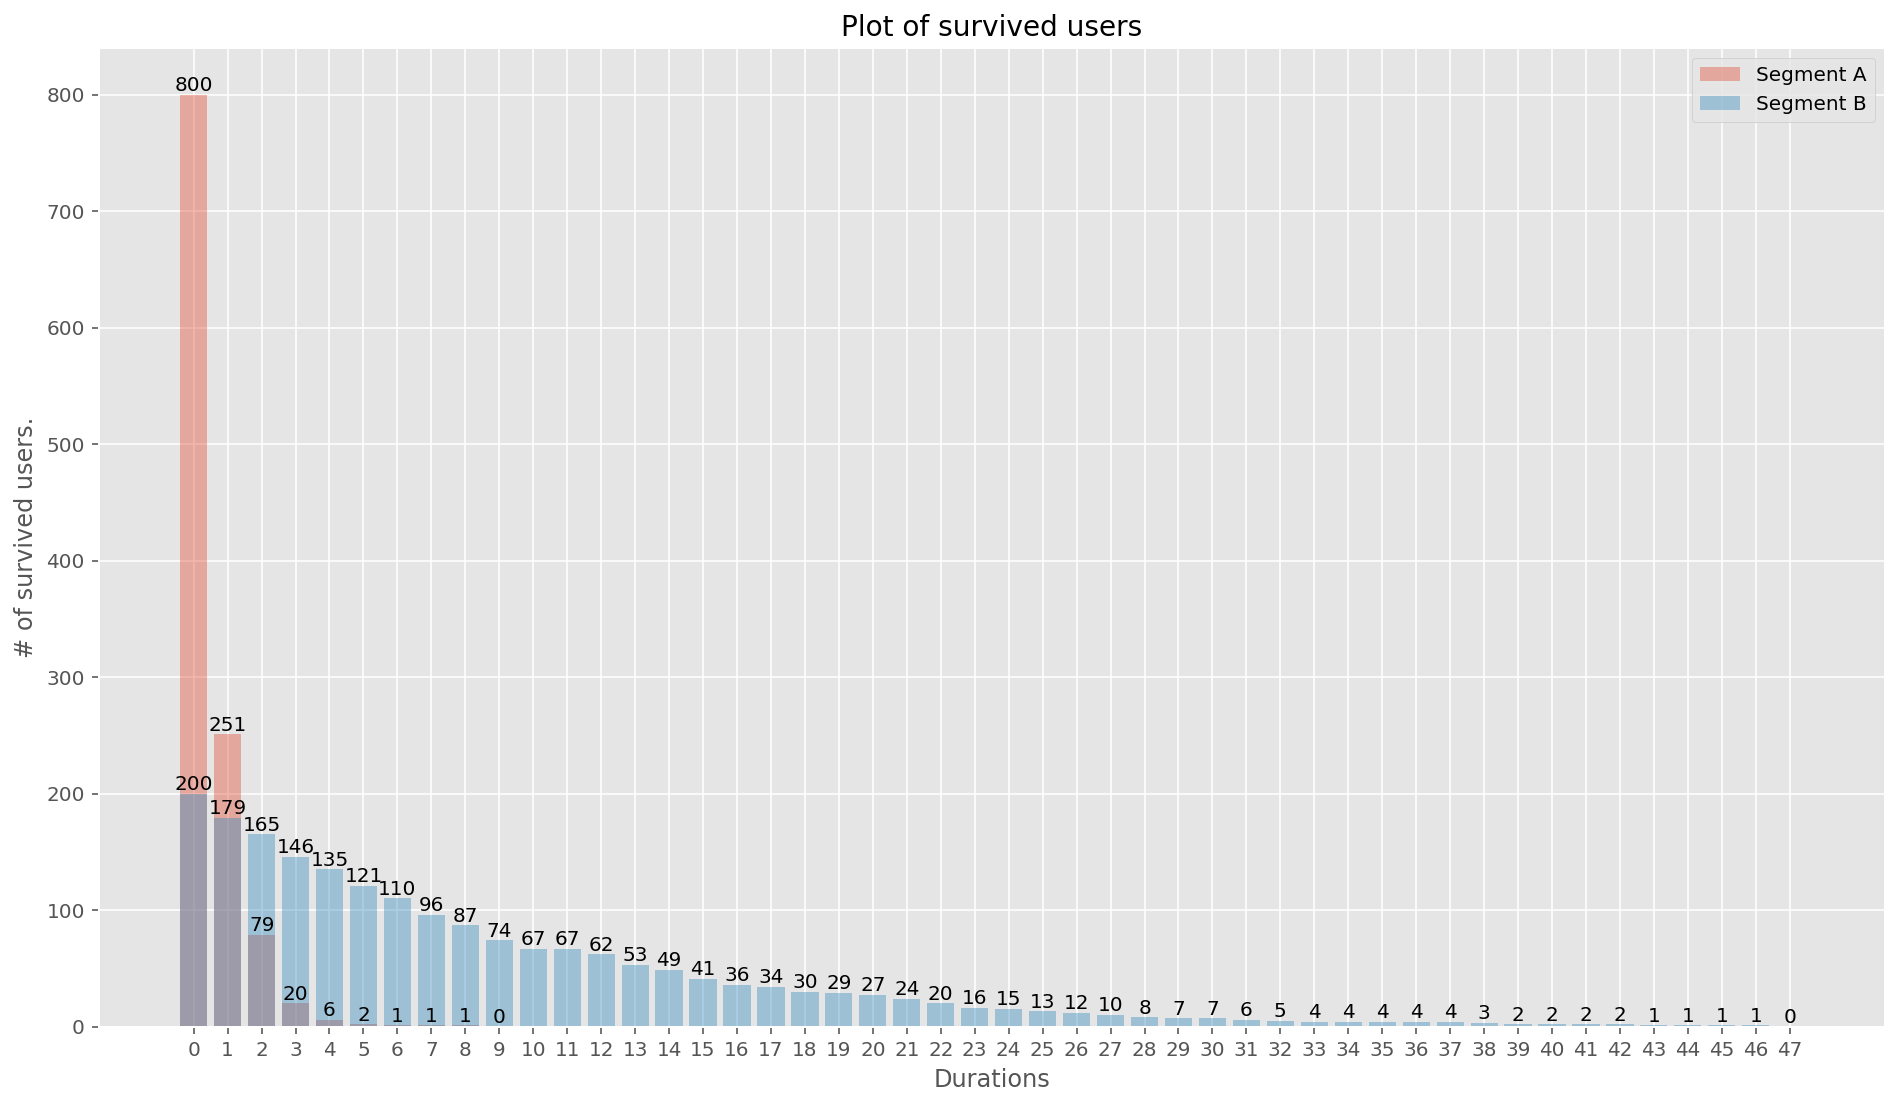

In [6]:

ax = plot_survives(df[df['segment']=='A'], label='Segment A', yscale='linear', density=False)  #, bar_label=None, theta=0.7)
ax = plot_survives(df[df['segment']=='B'], label='Segment B', yscale='linear', density=False, ax=ax)  #, bar_label=None, theta=0.1)
plt.show()

## Bayesian inference with PyMC4

In [7]:
import arviz as az
import pymc as pm

az.style.use("arviz-darkgrid")

In [11]:
print(f'Running on pymc version: {pm.__version__}')

Running on pymc version: 4.1.5


### 2nd sample: Geometric distribution

In [ ]:
df

In [8]:
df['segment_id'] = pd.Categorical(df['segment']).codes

In [9]:
df_train, df_test = train_test_split(df.loc[:, df.columns != 'segment'], test_size=0.3, random_state=1)

In [10]:
df_train

,churn_dates,segment_id
731,1,0
716,1,0
640,1,0
804,2,0
737,1,0
...,...,...
767,1,0
72,5,1
908,1,0
235,2,0


In [11]:
X_train, X_test = df_train['segment_id'], df_test['segment_id']
y_train, y_test = df_train['churn_dates'], df_test['churn_dates']
# y_train, y_test = df_train.sum(axis=1).astype('int'), df_test.sum(axis=1).astype('int')
# X_train = X_train.apply(lambda r: 1 if r=='B' else 0)
# X_test = X_test.apply(lambda r: 1 if r=='B' else 0)

In [26]:
init_variables(['idata', 'model'])

model = pm.Model()

with model:
    # alpha = pm.HalfNormal('alpha', sigma=100)
    # beta = pm.HalfNormal('beta', sigma=100)
    theta_core = pm.Beta('theta_core', 1., 1.)
    mu = pm.Normal('mu', 0., 0.1, shape=[X_train.max()+1])
    # sigma = pm.HalfNormal('sigma', sigma=0.1)
    x_ = pm.Data('features', X_train.values, mutable=True)

    # theta = pm.Beta('theta', alpha[X_train.values], beta[X_train.values])  # + tscale
    # theta = pm.Deterministic('theta', theta_core + mu[X_train.values])
    # obs = pm.Geometric('obs', theta_core + mu[X_train.values], observed=y_train.values)
    obs = pm.Geometric('obs', theta_core + mu[x_], observed=y_train.values)
    # obs = pm.Geometric('obs', theta, observed=y_train.values)


In [27]:
with model:
    idata = pm.sample(draws=2000, target_accept=0.9)

/Users/yukoga/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/yukoga/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/yukoga/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/yukoga/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma 

In [28]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],0.294,0.069,0.159,0.417,0.002,0.001,1283.0,1359.0,1.0
mu[1],-0.297,0.069,-0.427,-0.170,0.002,0.001,1273.0,1397.0,1.0
theta_core,0.402,0.069,0.276,0.533,0.002,0.001,1271.0,1396.0,1.0


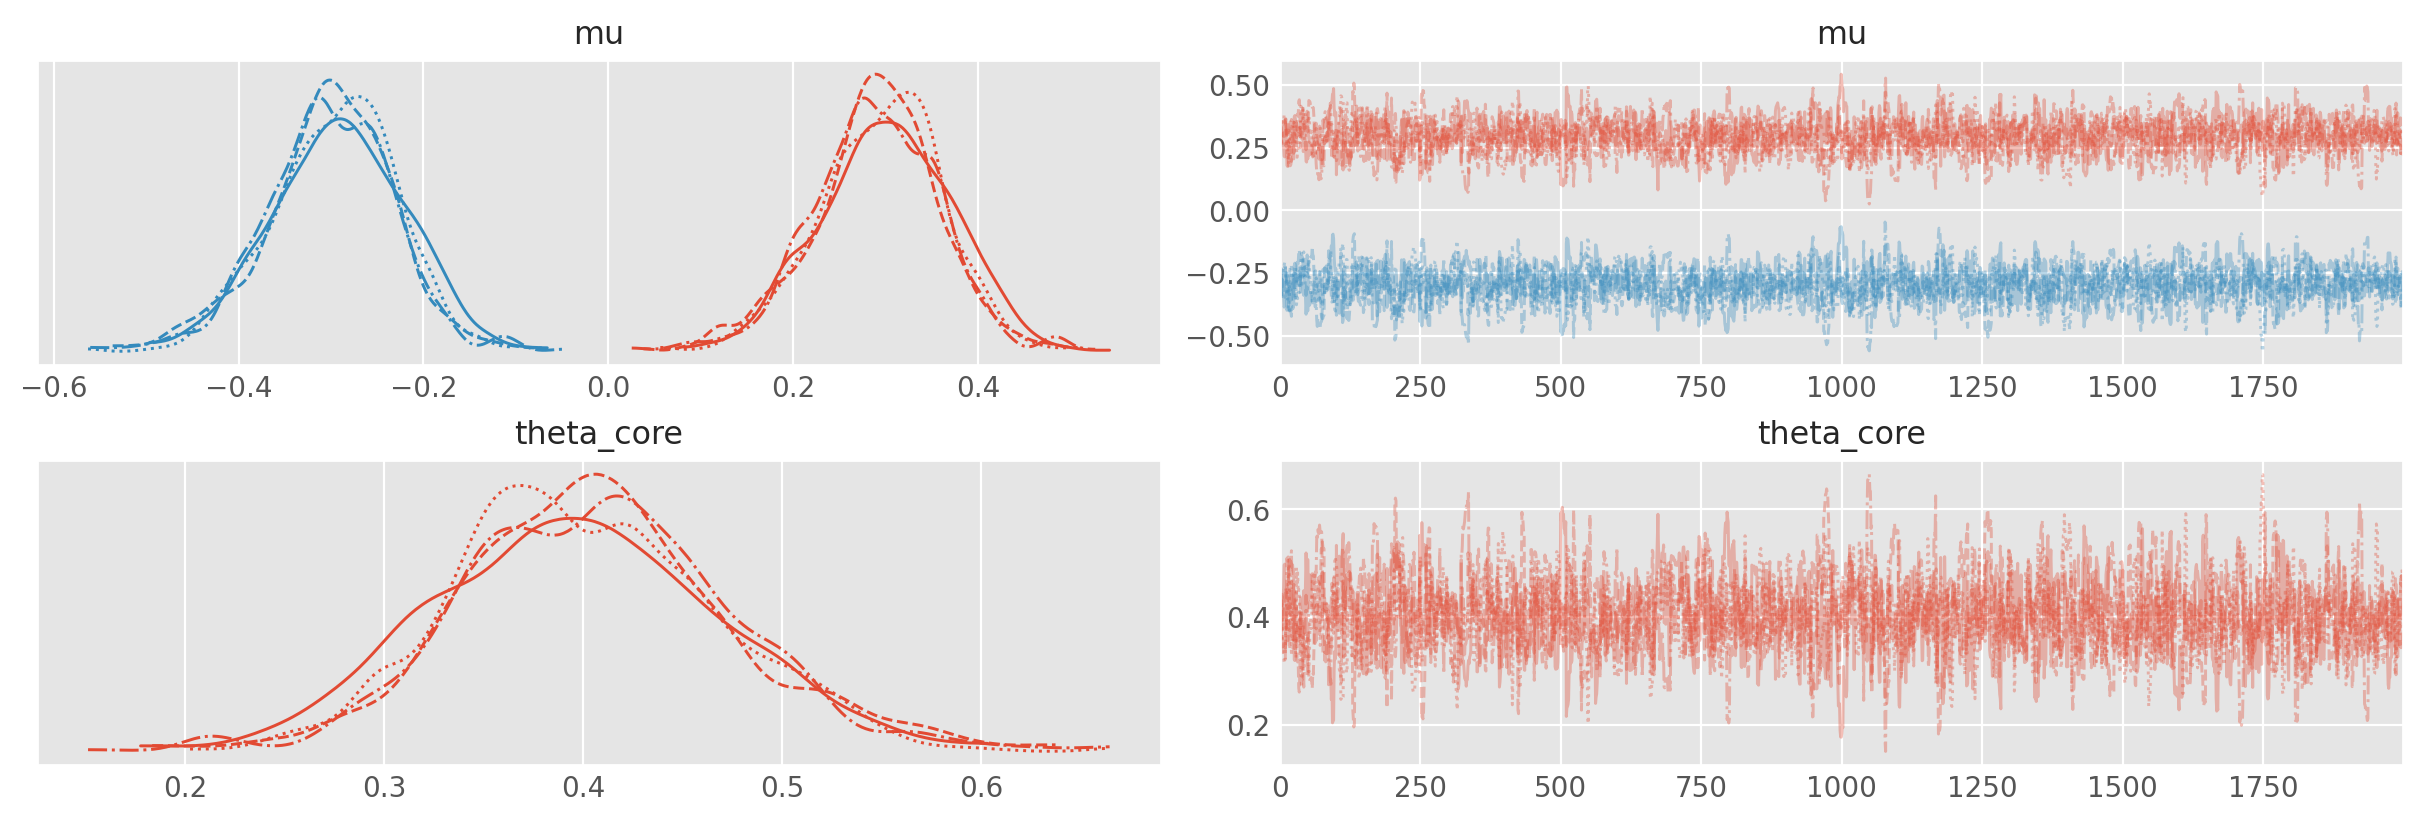

In [29]:
az.plot_trace(idata, ['mu', 'theta_core']);

In [24]:
az.waic(idata)

Computed from 8000 posterior samples and 700 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -932.04    35.55
p_waic        1.94        -

In [ ]:
idata.keys()

In [ ]:
mu = idata.posterior.mu.mean(axis=0)
mu.values.shape

In [ ]:
theta_core = idata.posterior.theta_core.mean(axis=0)
theta_core.values.shape

In [ ]:
theta_a = theta_core.values + mu.values[:, 0]
theta_b = theta_core.values + mu.values[:, 1]

In [ ]:
df_params = pd.DataFrame({'theta_core': theta_core.values, 'mu_lower': mu.values[:, 0], 'mu_upper': mu.values[:, 1], 'theta_a': theta_a, 'theta_b': theta_b})

In [100]:
with model:
    pm.set_data({'features': X_test.values})
    posterior = pm.sample_posterior_predictive(idata, extend_inferencedata=True)

In [102]:
posterior

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [103]:
y_pred = posterior.posterior_predictive['obs']

In [104]:
y_test

507    2
818    1
452    2
368    1
242    1
      ..
459    2
415    2
61     3
347    1
349    1
Name: churn_dates, Length: 300, dtype: int32

In [105]:
y_pred_mean = y_pred.mean(dim=('chain', 'draw'))
y_pred_std = y_pred.std(dim=('chain', 'draw'))
ci_95 = az.hdi(posterior.posterior_predictive, hdi_prob=0.95)['obs']

pred_result = pd.DataFrame(np.vstack([y_pred_mean,y_pred_std,ci_95[:,0],ci_95[:,1]]).T)
pred_result.columns= ['mean','std','lower','upper']

In [112]:
df_result = pd.concat([df_test.reset_index(), pred_result], axis=1, ignore_index=True)
df_result.columns = ['user_id', 'churn_dates', 'segment_id', 'y_pred_mean', 'y_pred_std', 'ci95_lw', 'ci95_up']

In [113]:
df_result.head()

,user_id,churn_dates,segment_id,y_pred_mean,y_pred_std,ci95_lw,ci95_up
0,507,2,0,1.444375,0.800566,1.0,3.0
1,818,1,0,1.435375,0.786653,1.0,3.0
2,452,2,0,1.432250,0.799006,1.0,3.0
3,368,1,0,1.441875,0.804439,1.0,3.0
4,242,1,0,1.449625,0.798569,1.0,3.0


In [114]:
index_a = df_result[df_result['segment_id']==0].index
index_b = df_result[df_result['segment_id']==1].index

In [122]:
df_result.loc[index_b, :].describe()

,user_id,churn_dates,segment_id,y_pred_mean,y_pred_std,ci95_lw,ci95_up
count,62.000000,62.000000,62.0,62.000000,62.000000,62.0,62.000000
mean,98.048387,10.274194,1.0,9.606938,9.156263,1.0,27.887097
std,59.004703,9.904742,0.0,0.104805,0.163464,0.0,0.482644
min,2.000000,1.000000,1.0,9.389000,8.848643,1.0,27.000000
25%,51.500000,3.000000,1.0,9.540781,9.020826,1.0,28.000000
50%,100.000000,8.000000,1.0,9.612562,9.149025,1.0,28.000000
75%,146.500000,14.000000,1.0,9.683563,9.267112,1.0,28.000000
max,195.000000,47.000000,1.0,9.919125,9.570097,1.0,29.000000


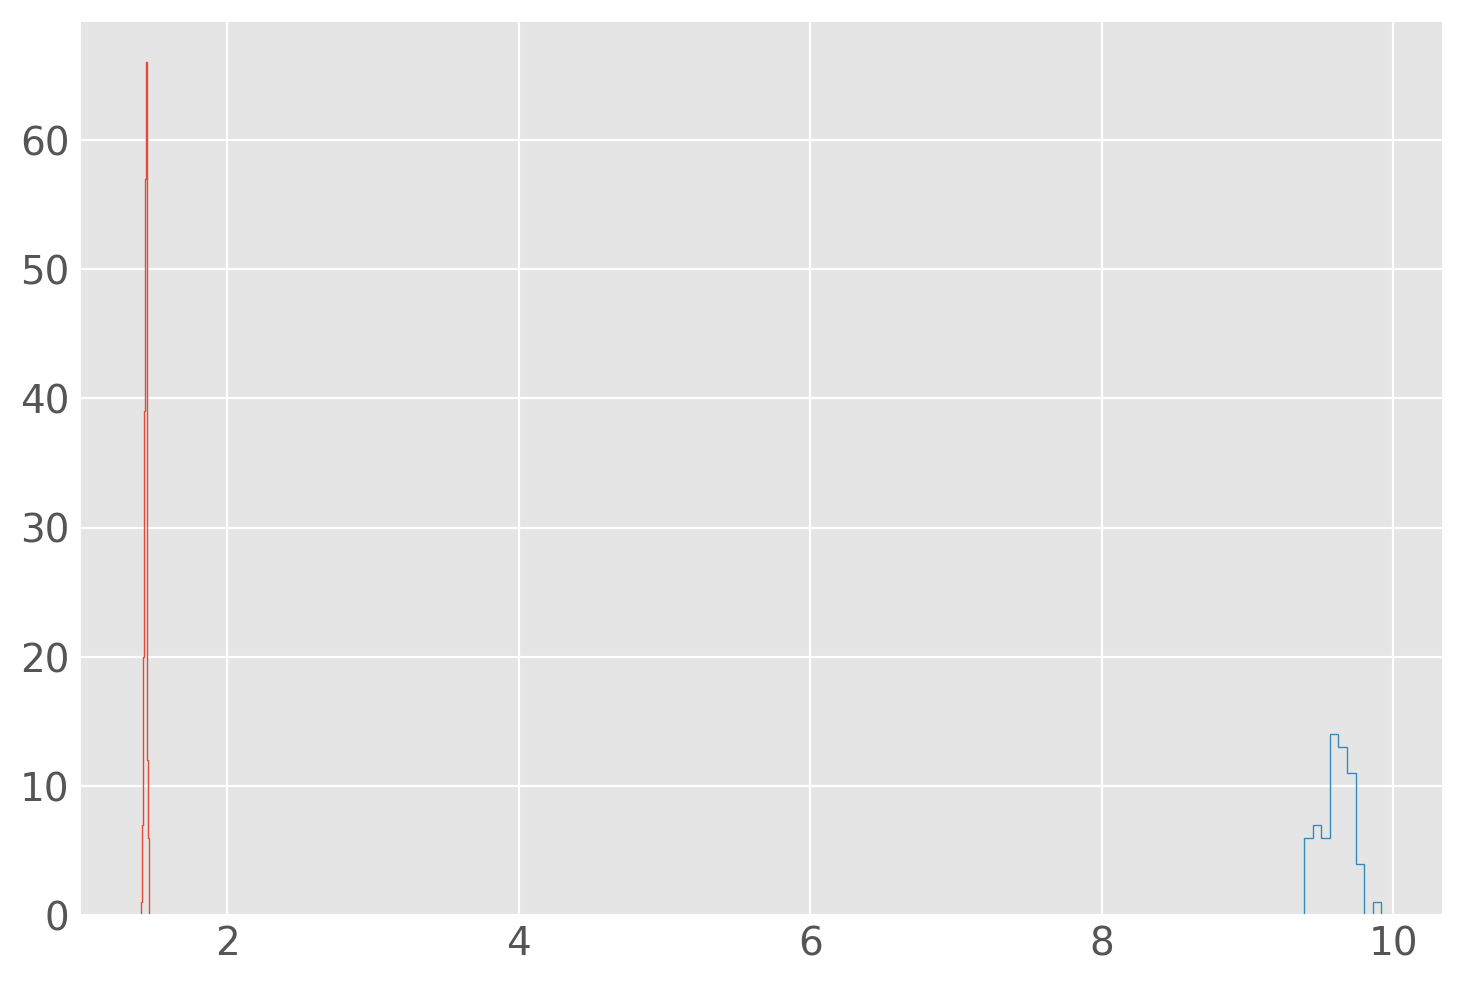

In [120]:
# ax = plot_survives(df_result.loc[index_a, :], label='Segment A', yscale='linear', density=False)  #, bar_label=None, theta=0.7)
# ax = plot_survives(df_result.loc[index_b, :], label='Segment B', yscale='linear', density=False, ax=ax)  #, bar_label=None, theta=0.1)
plt.hist(df_result.loc[index_a, 'y_pred_mean'], histtype='step', bins=9)
plt.hist(df_result.loc[index_b, 'y_pred_mean'], histtype='step', bins=9)
plt.show()

In [78]:
pred_result[index_a]

KeyError: "None of [Int64Index([507, 818, 452, 368, 242, 929, 262, 810, 318, 446,\n            ...\n            435, 980, 632, 286, 582, 899, 459, 415, 347, 349],\n           dtype='int64', length=238)] are in the [columns]"

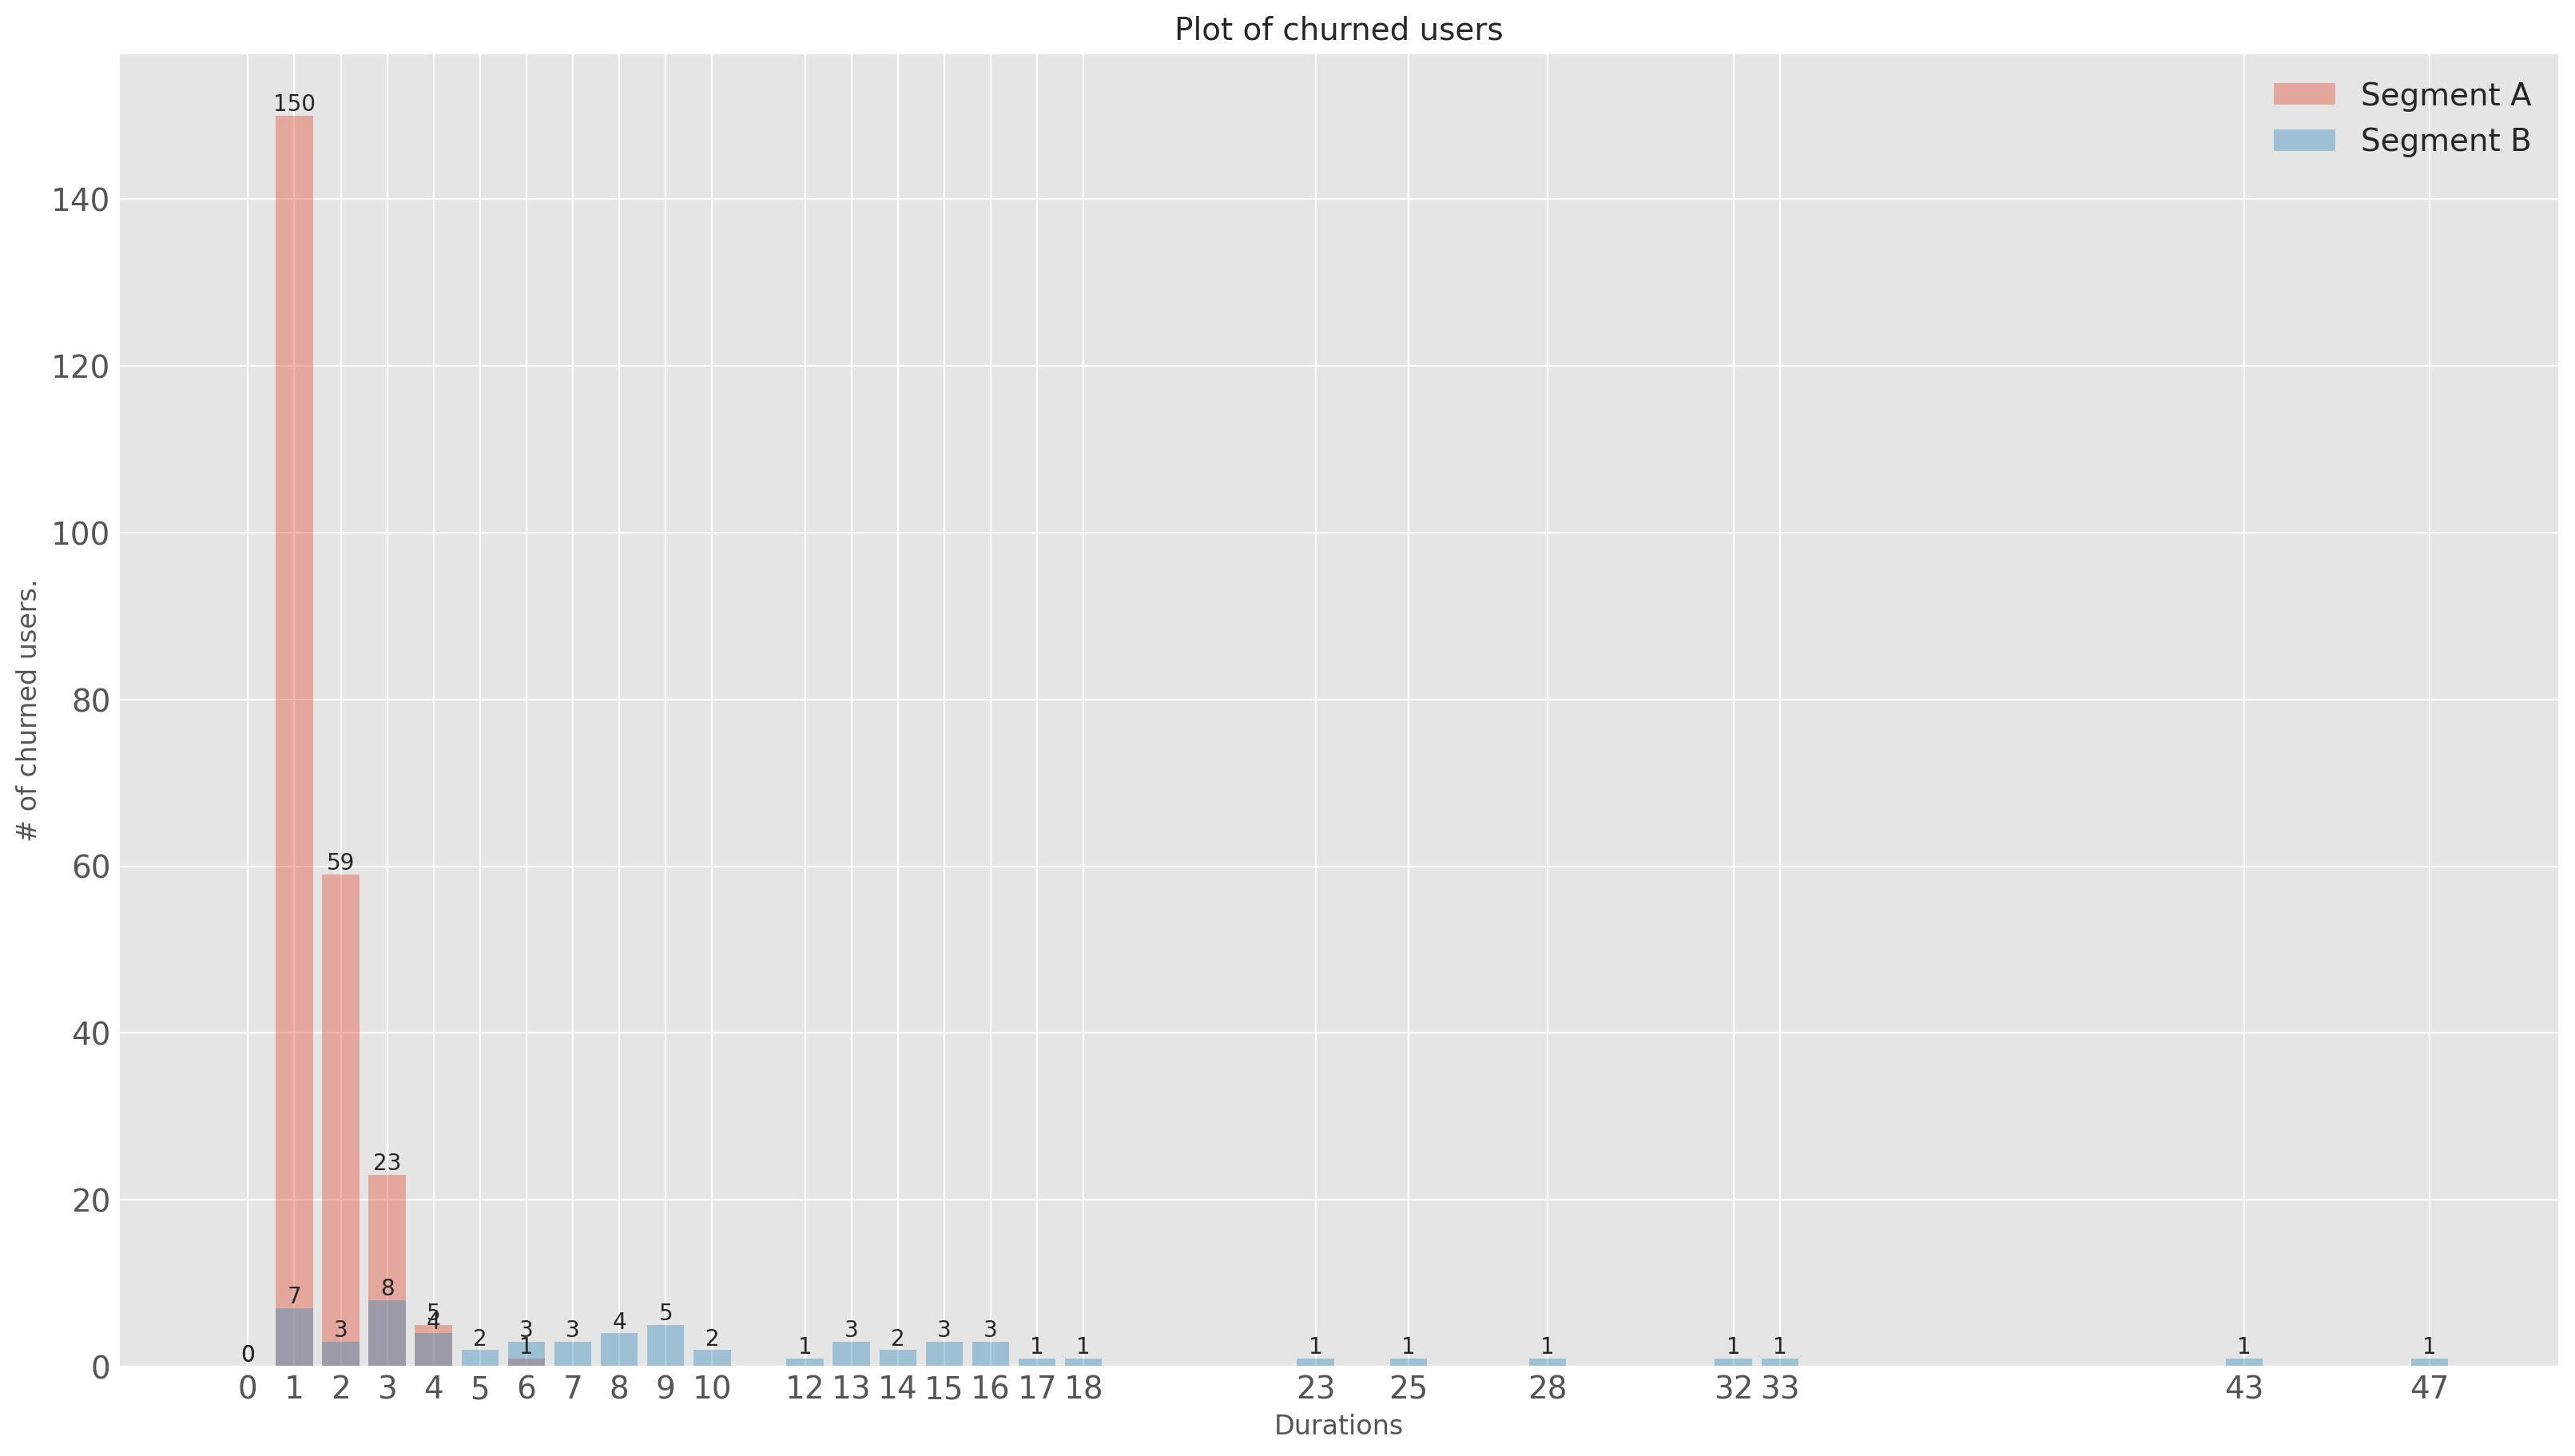

In [76]:
ax = plot_churns(df_test.loc[index_a, :], label='Segment A', yscale='linear', density=False)  #, bar_label=None, theta=0.7)
ax = plot_churns(df_test.loc[index_b, :], label='Segment B', yscale='linear', density=False, ax=ax)  #, bar_label=None, theta=0.1)
plt.show()

In [ ]:
poste